In [32]:
# =====================================
# Sensitivity Analysis (±10%)
# =====================================

import sys
from pathlib import Path
import importlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.float_format", lambda x: f"{x:,.3f}")
plt.rcParams["figure.dpi"] = 140

# Add project root to path
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

# Force reload in case src files were edited
import src.model
import src.metrics
importlib.reload(src.model)
importlib.reload(src.metrics)

from src.model import build_policy_table
from src.metrics import add_cost_per_ton_metrics


In [33]:
# Base policy inputs (same as Notebook 01)

policy_inputs = [
    {"Policy": "Baseline", "Y_TWh": 448, "C_g_per_kWh": 570, "Gov_Impact_$B": 0.00,  "Firm_Impact_$B": 0.00},
    {"Policy": "Carbon Tax ($30/ton)", "Y_TWh": 403, "C_g_per_kWh": 513, "Gov_Impact_$B": +6.63, "Firm_Impact_$B": -7.66},
    {"Policy": "Clean Energy Subsidy", "Y_TWh": 480, "C_g_per_kWh": 412, "Gov_Impact_$B": -2.25, "Firm_Impact_$B": -2.83},
    {"Policy": "Dynamic Energy Pricing", "Y_TWh": 490, "C_g_per_kWh": 426, "Gov_Impact_$B": -0.07, "Firm_Impact_$B": -4.65},
    {"Policy": "Clean Energy Mandate (50%)", "Y_TWh": 480, "C_g_per_kWh": 500, "Gov_Impact_$B": -0.05, "Firm_Impact_$B": -2.24},
]

df_base = build_policy_table(policy_inputs)
df_base = add_cost_per_ton_metrics(df_base)

df_base[["Policy", "Emissions_MMT", "Abatement_MMT"]].round(3)


,Policy,Emissions_MMT,Abatement_MMT
0,Baseline,255.360,0.000
1,Carbon Tax ($30/ton),206.739,48.621
2,Clean Energy Subsidy,197.760,57.600
3,Dynamic Energy Pricing,208.740,46.620
4,Clean Energy Mandate (50%),240.000,15.360


In [34]:
def run_sensitivity(policy_inputs: list[dict], shock: float = 0.10) -> pd.DataFrame:
    """
    Sensitivity analysis applying ± shock to Y and C.
    """

    base_table = build_policy_table(policy_inputs)
    baseline_E = base_table.loc[base_table["Policy"] == "Baseline", "Emissions_MMT"].iloc[0]

    scenarios = [
        ("Base", 1.0, 1.0),
        ("Y +10%", 1.0 + shock, 1.0),
        ("Y -10%", 1.0 - shock, 1.0),
        ("C +10%", 1.0, 1.0 + shock),
        ("C -10%", 1.0, 1.0 - shock),
        ("Y +10%, C +10%", 1.0 + shock, 1.0 + shock),
        ("Y -10%, C -10%", 1.0 - shock, 1.0 - shock),
    ]

    rows = []

    for policy in policy_inputs:
        for scen, y_mult, c_mult in scenarios:
            tmp_inputs = [{
                "Policy": policy["Policy"],
                "Y_TWh": policy["Y_TWh"] * y_mult,
                "C_g_per_kWh": policy["C_g_per_kWh"] * c_mult,
                "Gov_Impact_$B": policy["Gov_Impact_$B"],
                "Firm_Impact_$B": policy["Firm_Impact_$B"],
            }]

            tmp = build_policy_table(tmp_inputs, baseline_emissions=baseline_E)

            rows.append({
                "Policy": policy["Policy"],
                "Scenario": scen,
                "Emissions_MMT": float(tmp["Emissions_MMT"].iloc[0]),
                "Abatement_MMT": float(tmp["Abatement_MMT"].iloc[0]),
            })

    return pd.DataFrame(rows)


In [35]:
sens = run_sensitivity(policy_inputs, shock=0.10)

sens[sens["Policy"] == "Baseline"][["Scenario", "Emissions_MMT", "Abatement_MMT"]].round(3)


,Scenario,Emissions_MMT,Abatement_MMT
0,Base,255.360,0.000
1,Y +10%,280.896,-25.536
2,Y -10%,229.824,25.536
3,C +10%,280.896,-25.536
4,C -10%,229.824,25.536
5,"Y +10%, C +10%",308.986,-53.626
6,"Y -10%, C -10%",206.842,48.518


In [36]:
pivot_emissions = sens.pivot(
    index="Policy",
    columns="Scenario",
    values="Emissions_MMT"
).round(3)

pivot_emissions


Scenario,Base,C +10%,C -10%,Y +10%,"Y +10%, C +10%",Y -10%,"Y -10%, C -10%"
Policy,,,,,,,
Baseline,255.360,280.896,229.824,280.896,308.986,229.824,206.842
Carbon Tax ($30/ton),206.739,227.413,186.065,227.413,250.154,186.065,167.459
Clean Energy Mandate (50%),240.000,264.000,216.000,264.000,290.400,216.000,194.400
Clean Energy Subsidy,197.760,217.536,177.984,217.536,239.290,177.984,160.186
Dynamic Energy Pricing,208.740,229.614,187.866,229.614,252.575,187.866,169.079


In [37]:
range_table = sens.groupby("Policy")["Emissions_MMT"].agg(["min", "max"])
range_table["Range"] = range_table["max"] - range_table["min"]
range_table.round(3)


,min,max,Range
Policy,,,
Baseline,206.842,308.986,102.144
Carbon Tax ($30/ton),167.459,250.154,82.696
Clean Energy Mandate (50%),194.400,290.400,96.000
Clean Energy Subsidy,160.186,239.290,79.104
Dynamic Energy Pricing,169.079,252.575,83.496


In [38]:
output_path = PROJECT_ROOT / "outputs" / "tables" / "sensitivity_range_table.csv"
range_table.to_csv(output_path)

output_path


WindowsPath('c:/Users/Finn Case/OneDrive/Desktop/ai-datacenter-policy-model/.vscode/outputs/tables/sensitivity_range_table.csv')

In [39]:
robust = sens[sens["Policy"] != "Baseline"] \
    .groupby("Policy")["Emissions_MMT"] \
    .agg(["min", "max", "mean"])

robust["Range"] = robust["max"] - robust["min"]
robust = robust.sort_values("mean")

robust


,min,max,mean,Range
Policy,,,,
Clean Energy Subsidy,160.186,239.290,198.325,79.104
Carbon Tax ($30/ton),167.459,250.154,207.330,82.696
Dynamic Energy Pricing,169.079,252.575,209.336,83.496
Clean Energy Mandate (50%),194.400,290.400,240.686,96.000


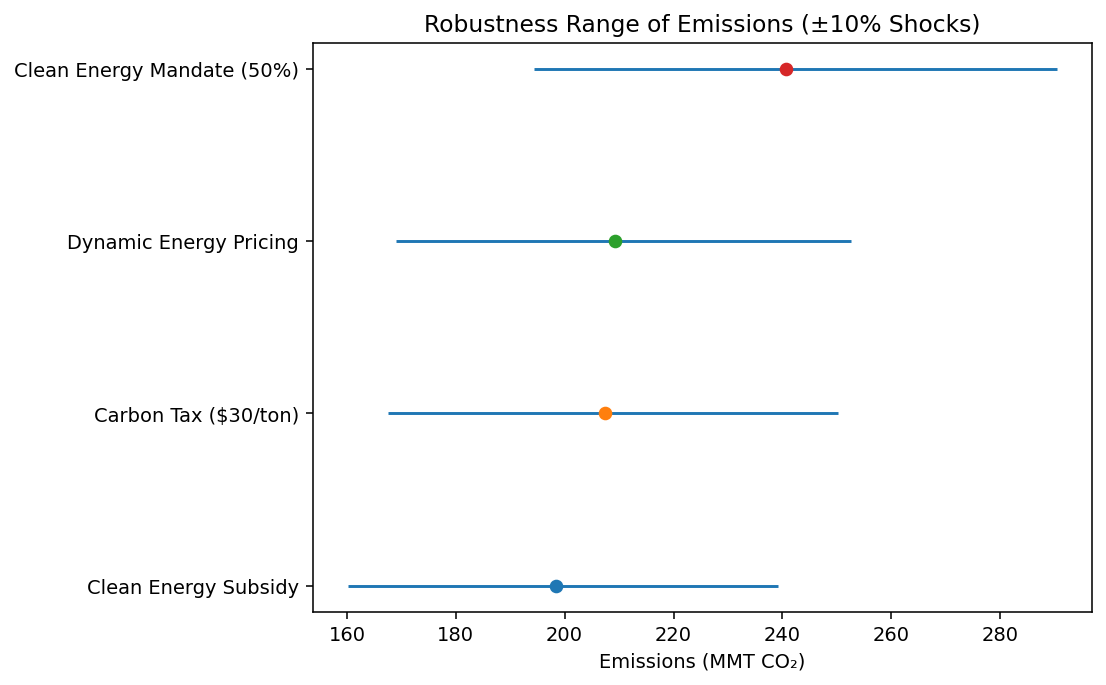

In [40]:
fig, ax = plt.subplots(figsize=(8,5))

for i, policy in enumerate(robust.index):
    ax.hlines(
        y=i,
        xmin=robust.loc[policy, "min"],
        xmax=robust.loc[policy, "max"]
    )
    ax.plot(
        robust.loc[policy, "mean"],
        i,
        "o"
    )

ax.set_yticks(range(len(robust.index)))
ax.set_yticklabels(robust.index)
ax.set_xlabel("Emissions (MMT CO₂)")
ax.set_title("Robustness Range of Emissions (±10% Shocks)")

plt.tight_layout()
plt.show()
